In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from solvers import * 

In [3]:
from plot import * 

In [4]:
# df = pd.read_csv('./india_case_counts.csv')
# I_real = df.iloc[91:]['Active Infections']
# deltaI_real = df.iloc[91:]['Daily Confirmed']

df = pd.read_csv('./data/time_series_covid19_confirmed_global.csv')
df = df.drop(['Lat', 'Long'], axis =1)
df = df.groupby('Country/Region').agg('sum')
df = df.loc['India'][98:]
print(df.tail())
I_real = list(df)
print(len(I_real))
deltaI_real = np.array([I_real[i]-I_real[i-1] for i in range(1, len(I_real))])

12/19/20    10031223
12/20/20    10055560
12/21/20    10075116
12/22/20    10099066
12/23/20    10123778
Name: India, dtype: int64
239


In [176]:
N = 1366417755 #India's Population
# N = 127575528  #Mexico's Population
# N = 17097123 #Netherland's Population
underreporting_factor = 50.

R0 = 0

Istar = N/500
print(Istar)

r = 1
e = r/Istar
gamma = 1/5.

I0 = deltaI_real[0]*underreporting_factor/gamma
S0 = N - I0 - R0
beta0 = gamma*N/S0
# Istar = r/e
Jstar = gamma*N
init = (S0, I0, R0)
delta_t = 0.001

tsteps = 500
t = np.linspace(0, tsteps-1, tsteps)
eta = 5
# i = np.zeros(tsteps)
# spikes = [(50, 0), (100, 0)]
# for (pos, spike) in spikes:
#     i[pos] = spike



2732835.51


In [177]:
R_intervention_h = 0.8
R_intervention_l = 0.5
beta_intervention_h = R_intervention_h*gamma
beta_intervention_l = R_intervention_l*gamma
R_relaxation = 2.2
beta_relaxation = R_relaxation*gamma
beta_dI_h = []
beta_dI_l = []
T_intervention = 40
T_relaxation = 20
temp = 0
while temp < tsteps:
    if(temp+T_intervention>=tsteps):
        beta_dI_h.extend([beta_intervention_h for i in range(tsteps - temp)])
        beta_dI_l.extend([beta_intervention_l for i in range(tsteps - temp)])
        temp += tsteps - temp
    else:
        beta_dI_h.extend([beta_intervention_h for i in range(T_intervention)])
        beta_dI_l.extend([beta_intervention_l for i in range(T_intervention)])
        beta_dI_h.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))]) 
        beta_dI_l.extend([beta_relaxation for i in range(min(T_relaxation, tsteps - temp))])
        temp += T_intervention + min(T_relaxation, tsteps - temp)
beta_dI_h = np.array(beta_dI_h)
beta_dI_l = np.array(beta_dI_l)

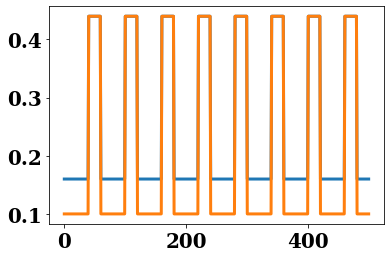

In [178]:
plt.plot(t, beta_dI_h)
plt.plot(t, beta_dI_l)

In [179]:
S_dI_h, I_dI_h, R_dI_h = solve_discrete_sir((S0, I0, R0), beta_dI_h, gamma, N, tsteps, delta_t=delta_t)
S_dI_l, I_dI_l, R_dI_l = solve_discrete_sir((S0, I0, R0), beta_dI_l, gamma, N, tsteps, delta_t=delta_t)

beta_cons = 2.2*gamma
S_cons, I_cons, R_cons = solve_discrete_sir((S0, I0, R0), beta_cons, gamma, N, tsteps, delta_t=delta_t)

In [180]:
def find_approximation(beta, klevels, loss_function):
    """
        Find the best approximation of beta (m,) sized array
        based on one of the klevels (k,) sized array. The
        goodness of approximation is based on 

        loss_function: (y, y_hat) -> R (positive reals)

        Returns: beta_approx (m,) sized array
        such that: 
            
            \sum_t loss_function(beta_approx(t), beta(t))
        i.e. pointwise loss values are minimized.

        Since, loss_function is positive and pointwise,
        elementwise minimum should minimise the global objective.

        TODO: Should we impose some sort of smoothness constraint
        on beta_approx(t) ?
    """
    num_steps = np.shape(beta)[0]
    num_levels = np.shape(klevels)[0]
    
    #TODO: Try out a vectorized implementation
    beta_approx = []
    for t in range(num_steps):
        beta_val = beta[t]
        losses = loss_function(beta_val, klevels)
        best_beta = klevels[np.argmin(losses)]
        beta_approx.append(best_beta)

    beta_approx = np.array(beta_approx)
    return beta_approx

In [181]:
S_ideal, I_ideal, R_ideal, beta_ideal = solve_sir_lv_control(S0, I0, R0, beta0, N, r, e, gamma, eta, t)

In [182]:
klevels = np.array([0.05*i for i in range(1,11)])
print(klevels)
loss_function = lambda x,y: (x-y)**2
beta_approx = find_approximation(beta_ideal, klevels, loss_function)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


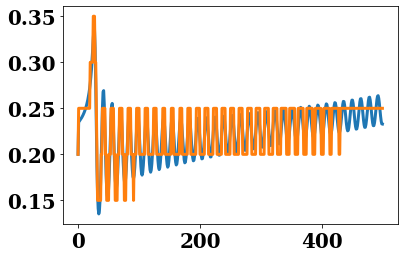

In [185]:
x = len(beta_ideal)
plt.plot(range(len(beta_ideal[:x])), beta_ideal[:x])
plt.plot(range(len(beta_ideal[:x])), beta_approx[:x])

In [186]:
S_approx, I_approx, R_approx = solve_discrete_sir((S0, I0, R0), beta_approx, gamma, N, tsteps, delta_t=delta_t)

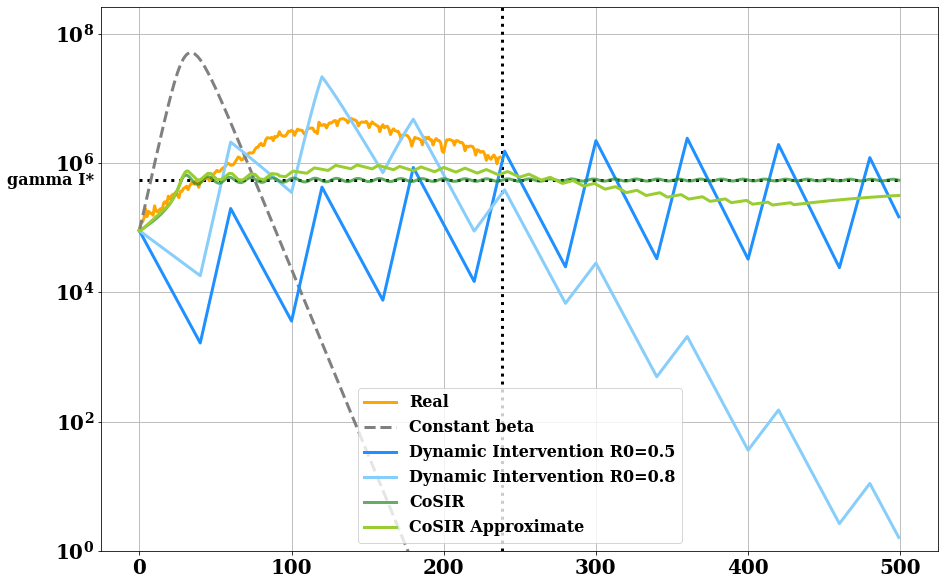

In [187]:
# plt.figure(figsize = (15, 10))
# plt.grid()
# plt.yscale("log")
# plt.ylim([1, 1e+9])
# plt.yticks([1, 10, 100, 1000, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8])
# # plt.plot(t, S, label="CoSIR")
# # plt.plot(t, S_approx, label="CoSIR Approx")
# # plt.plot(t, S_dI, label = "Dynamic Intervention")
# plt.plot(t, I_ideal*gamma, label="CoSIR")
# plt.plot(t, I_approx*gamma, label="CoSIR Approx")
# plt.plot(t, I_cons*gamma, label= r'Constant \beta')
# plt.plot(t, I_dI_h*gamma, label = "Dynamic Intervention R = 0.8")
# plt.plot(t, I_dI_l*gamma, label = "Dynamic Intervention R = 0.5")
# plt.axhline(y=Istar*gamma, linestyle = '--', color = 'black')
# plt.axvline(x = len(deltaI_real), linestyle = '--')
# plt.plot(range(len(deltaI_real)), deltaI_real*50, label = "Real")
# plt.legend()
# # plt.plot(t, R)


import matplotlib.transforms as transforms
fig, ax = plt.subplots(figsize=(15,10))
plt.yscale('log')
plt.ylim(top=np.max(I_cons)*1.01, bottom=1)
plt.tick_params(axis='y', which='minor', left=False, right=False)


plt.hlines(y=Istar*gamma, xmin=0, xmax=500, linestyles='dotted')
plt.axvline(x=len(deltaI_real), ls=':', color='black')

trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, Istar*gamma, 'gamma I*', color="black", transform=trans, ha="right", va="center")

trans = transforms.blended_transform_factory(ax.get_xticklabels()[0].get_transform(), ax.transData)

ax.plot(range(len(deltaI_real)), deltaI_real*underreporting_factor, '-', label='Real', color='orange')

ax.plot(t, I_cons*gamma, label='Constant beta', ls='--', color='grey')

ax.plot(t, I_dI_l*gamma, label='Dynamic Intervention R0=0.5', color='dodgerblue')
ax.plot(t, I_dI_h*gamma, label='Dynamic Intervention R0=0.8', color='lightskyblue')

ax.plot(t, I_ideal*gamma, '-', alpha=0.7, label='CoSIR', color='forestgreen')
ax.plot(t, I_approx*gamma, '-', label='CoSIR Approximate', color='yellowgreen')
plt.grid()
plt.legend()

In [188]:
def getControlMetrics(I, Istar):
    c = 0
    for idx, i in enumerate(I):
        c += np.abs(i-Istar)/Istar
    return c/len(I)

l = len(I_real)
# print("Till Current t")
print("Constant beta: {:.3f}".format(getControlMetrics(I_cons[:l]*gamma, Istar*gamma)))
print("Real: {:.3f}".format(getControlMetrics(deltaI_real*underreporting_factor, Istar*gamma)))
print("Dynamic Intervention R=0.8: {:.3f}".format(getControlMetrics(I_dI_h[:l]*gamma, Istar*gamma)))
print("Dynamic Intervention R=0.5: {:.3f}".format(getControlMetrics(I_dI_l[:l]*gamma, Istar*gamma)))
print("Ideal beta: {:.3f}".format(getControlMetrics(I_ideal[:l]*gamma, Istar*gamma)))
print("Approx beta: {:.3f}".format(getControlMetrics(I_approx[:l]*gamma, Istar*gamma)))


# print()
# print()
# print("Till Current t=500")
# print("Constant beta: {}".format(getControlMetrics(I_cons*gamma, Istar*gamma)))
# print("Ideal beta: {}".format(getControlMetrics(I_ideal*gamma, Istar*gamma)))
# print("Approx beta: {}".format(getControlMetrics(I_approx*gamma, Istar*gamma)))
# print("Dynamic Intervention beta R=0.8: {}".format(getControlMetrics(I_dI_h*gamma, Istar*gamma)))
# print("Dynamic Intervention beta R=0.5: {}".format(getControlMetrics(I_dI_l*gamma, Istar*gamma)))

Constant beta: 9.162
Real: 3.037
Dynamic Intervention R=0.8: 3.568
Dynamic Intervention R=0.5: 0.825
Ideal beta: 0.116
Approx beta: 0.393


([<matplotlib.axis.XTick at 0x7fa96f092710>,
 <a list of 6 Text xticklabel objects>)

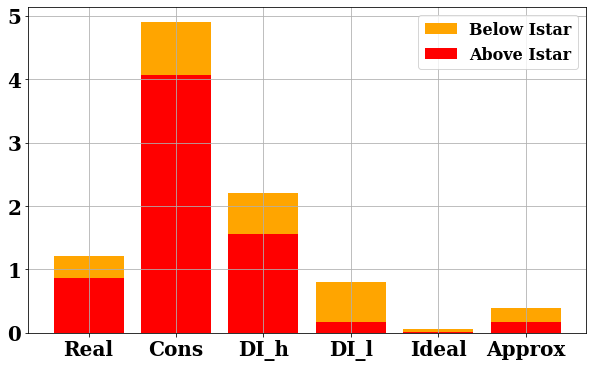

In [209]:
def getIBelowAboveIstar(I, Istar):
    below = 0
    above = 0
    for i in I:
        if(i<=Istar):
            below+=Istar-i
        else:
            above+=i-Istar
    return below/(len(I)*Istar), above/(len(I)*Istar)

belowAbove = {}
belowAbove['Real'] = getIBelowAboveIstar(I_real, Istar)
belowAbove['Cons'] = getIBelowAboveIstar(I_cons, Istar)
belowAbove['DI_h'] = getIBelowAboveIstar(I_dI_h, Istar)
belowAbove['DI_l'] = getIBelowAboveIstar(I_dI_l, Istar)
belowAbove['Ideal'] = getIBelowAboveIstar(I_ideal, Istar)
belowAbove['Approx'] = getIBelowAboveIstar(I_approx, Istar)

names = ['Real', 'Cons', 'DI_h', 'DI_l', 'Ideal', 'Approx']
belows = [belowAbove[n][0] for n in names]
aboves = [belowAbove[n][1] for n in names]
plt.figure(figsize=(10,6))
plt.grid()
plt.bar(range(len(names)), belows, bottom = aboves, width =0.8, color='orange', label = "Below Istar")
plt.bar(range(len(names)), aboves, width =0.8, color = 'red', label = "Above Istar")
plt.legend()
plt.xticks(range(len(names)), names)

([<matplotlib.axis.XTick at 0x7fa96f1e4dd8>,
 <a list of 6 Text xticklabel objects>)

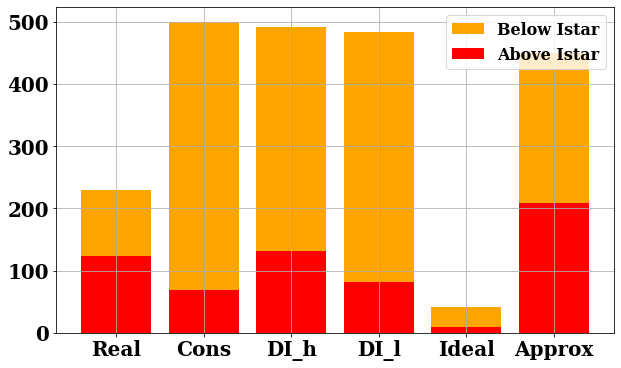

In [210]:
def getIBelowAboveIstar(I, Istar, buffer=0.1):
    below = 0
    above = 0
    for i in I:
        if(i<=Istar*(1-buffer)):
            below += 1
        elif(i>=Istar*(1+buffer)):
            above += 1
    return below, above

belowAbove = {}
belowAbove['Real'] = getIBelowAboveIstar(I_real, Istar)
belowAbove['Cons'] = getIBelowAboveIstar(I_cons, Istar)
belowAbove['DI_h'] = getIBelowAboveIstar(I_dI_h, Istar)
belowAbove['DI_l'] = getIBelowAboveIstar(I_dI_l, Istar)
belowAbove['Ideal'] = getIBelowAboveIstar(I_ideal, Istar)
belowAbove['Approx'] = getIBelowAboveIstar(I_approx, Istar)

names = ['Real', 'Cons', 'DI_h', 'DI_l', 'Ideal', 'Approx']
belows = [belowAbove[n][0] for n in names]
aboves = [belowAbove[n][1] for n in names]
plt.figure(figsize=(10,6))
plt.grid()
plt.bar(range(len(names)), belows, bottom = aboves, width =0.8, color='orange', label = "Below Istar")
plt.bar(range(len(names)), aboves, width =0.8, color = 'red', label = "Above Istar")
plt.legend()
plt.xticks(range(len(names)), names)

In [211]:
def betaTrend(betaList):
    below = []
    above = []
    minBeta = 0
    x = [minBeta + float(i)/20 for i in range(11)]
    for b in x:
        tempbelow = 0
        tempabove = 0
        for beta in betaList:
            if(beta<=b):
                tempbelow+=1
            else:
                tempabove+=1
        below.append(tempbelow)
        above.append(tempabove)
    return below, above, x
                

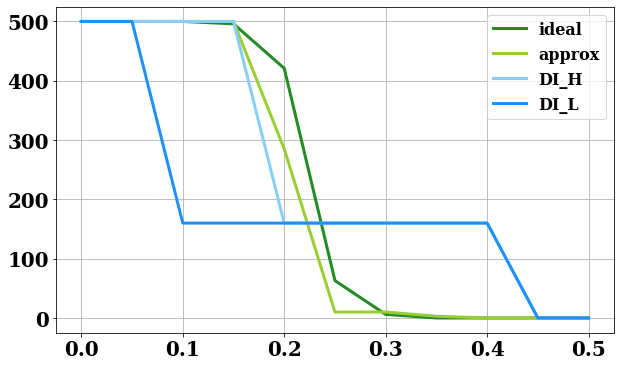

In [195]:
plt.figure(figsize=(10,6))
b, a, x = betaTrend(beta_ideal)
plt.plot(x, a, label='ideal', color='forestgreen')
b, a, x = betaTrend(beta_approx)
plt.plot(x, a, label = 'approx', color='yellowgreen')
b, a, x = betaTrend(beta_dI_h)
plt.plot(x, a, label = 'DI_H', color='lightskyblue')
b, a, x = betaTrend(beta_dI_l)
plt.plot(x, a, label = 'DI_L', color='dodgerblue')
plt.legend()
plt.grid()

<Figure size 432x288 with 0 Axes>

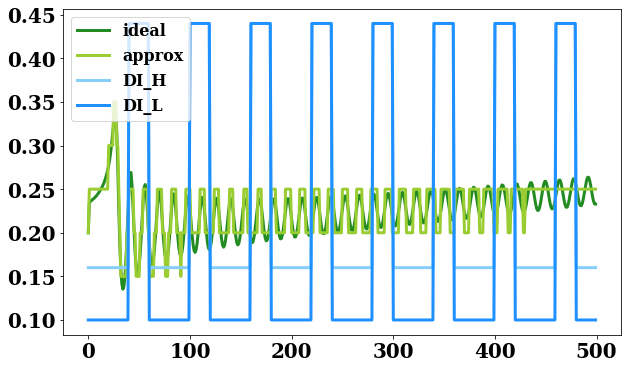

In [198]:
plt.clf()
plt.figure(figsize=(10,6))
l = len(beta_ideal)
plt.plot(range(l), beta_ideal, label='ideal', color='forestgreen')
plt.plot(range(l), beta_approx, label='approx', color='yellowgreen')
plt.plot(range(l), beta_dI_h, label='DI_H', color='lightskyblue')
plt.plot(range(l), beta_dI_l, label='DI_L', color='dodgerblue')
plt.legend()

In [196]:
Idict = {}
betadict = {}
Idict['CoSIR_Ideal'] = I_ideal
betadict['CoSIR_Ideal'] = beta_ideal

Idict['CoSIR_approx'] = I_approx
betadict['CoSIR_approx'] = beta_approx

Idict['Dynamic_Intervention_0.8'] = I_dI_h
betadict['Dynamic_Intervention_0.8'] = beta_dI_h

Idict['Dynamic_Intervention_0.5'] = I_dI_l
betadict['Dynamic_Intervention_0.5'] = beta_dI_l


Idict['Constant beta'] = I_cons
betadict['Constant beta'] = beta_cons

Idict['Real'] = I_real

In [18]:
Idf = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in Idict.items() ]))
betadf = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in betadict.items() ]))

In [19]:
Idf.to_csv('./Mexico_I.csv')
betadf.to_csv('./Mexico_beta.csv')